In [72]:
!pip install hyperopt
# from tsfeatures import tsfeatures


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.6 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 2.7 MB/s eta 0:00:00a 0:00:01


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, rand

In [40]:
google_stock_df = pd.read_csv('data/google-stock-dataset-Daily.csv')
google_stock_df

,Unnamed: 0,Date,Price,High,Low,Close,Volume,Adj Close
0,0,2013-04-15,19.67,19.94,19.44,19.57,98025876,19.57
1,1,2013-04-16,19.68,19.92,19.62,19.85,69610320,19.85
2,2,2013-04-17,19.69,19.79,19.47,19.58,81398520,19.58
3,3,2013-04-18,19.65,19.66,19.05,19.17,132767100,19.17
4,4,2013-04-19,19.25,20.11,19.18,20.02,231895872,20.02
...,...,...,...,...,...,...,...,...
2505,2505,2023-03-27,104.62,104.76,101.93,102.46,31120900,102.46
2506,2506,2023-03-28,102.44,102.45,99.74,101.03,32057900,101.03
2507,2507,2023-03-29,102.28,102.49,100.65,101.39,28779600,101.39
2508,2508,2023-03-30,100.91,101.16,99.78,100.89,33086200,100.89


In [41]:
# google_stock_df = google_stock_df.rename(columns={'Unnamed: 0': 'unique_id'})
# google_stock_df = google_stock_df.rename(columns={'Date': 'ds'})
# tsfeatures(google_stock_df, freq=1)

In [42]:
google_stock_df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [43]:
google_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2510 entries, 0 to 2509
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2510 non-null   object 
 1   Price      2510 non-null   float64
 2   High       2510 non-null   float64
 3   Low        2510 non-null   float64
 4   Close      2510 non-null   float64
 5   Volume     2510 non-null   int64  
 6   Adj Close  2510 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.4+ KB


In [44]:
google_stock_df.shape

(2510, 7)

In [45]:
google_stock_df.size

17570

In [46]:
def style():
    plt.figure(facecolor='black', figsize=(15,10))
    ax = plt.axes()

    ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to white
    ax.tick_params(axis='y', colors='white')    #setting up Y-axis tick color to white

    ax.spines['left'].set_color('white')        #setting up Y-axis spine color to white
    ax.spines['bottom'].set_color('white')      #setting up X-axis spine color to white

    # ax.set_facecolor("black")

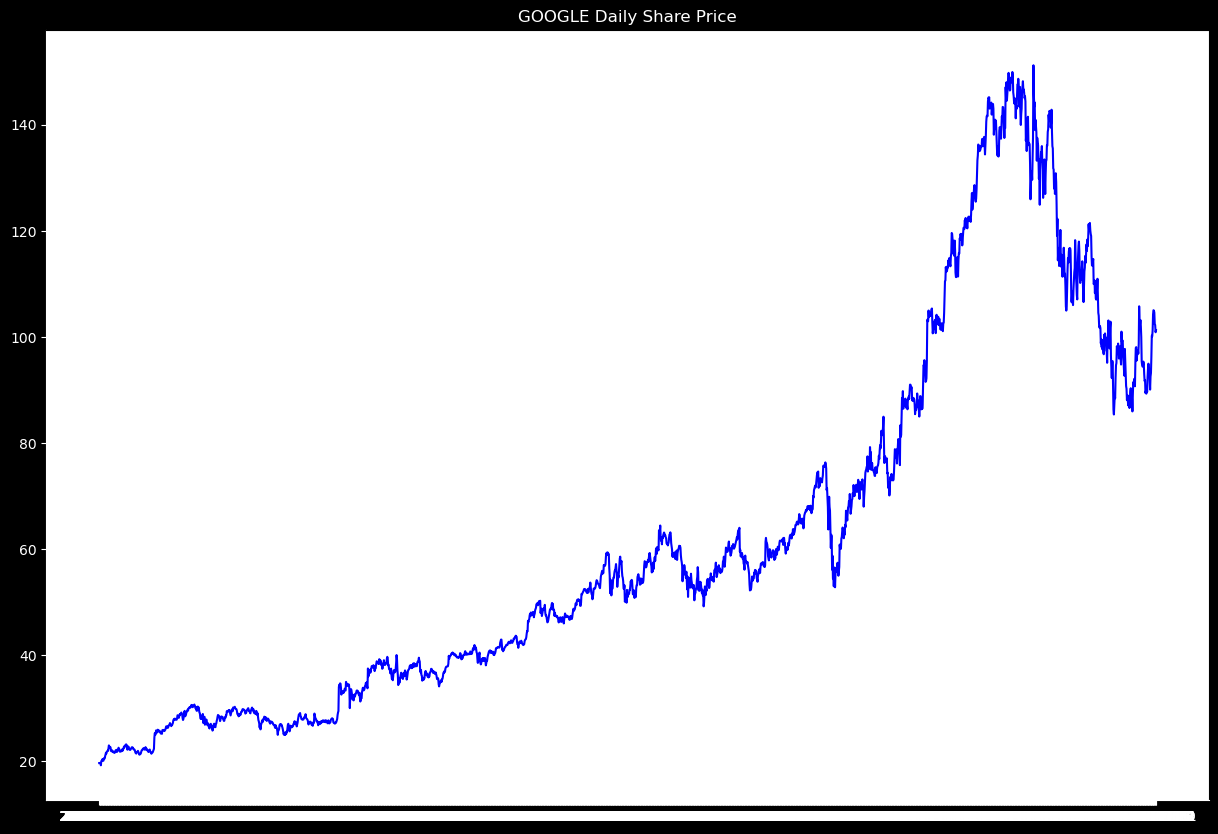

In [47]:
style()

plt.title("GOOGLE Daily Share Price", color='white')
plt.plot(google_stock_df['Date'], google_stock_df['Price'], color='blue')


In [87]:
google_stock_df_modelling = google_stock_df[['Date', 'Price', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
google_stock_df_modelling

,Date,Price,High,Low,Close,Adj Close,Volume
0,2013-04-15,19.67,19.94,19.44,19.57,19.57,98025876
1,2013-04-16,19.68,19.92,19.62,19.85,19.85,69610320
2,2013-04-17,19.69,19.79,19.47,19.58,19.58,81398520
3,2013-04-18,19.65,19.66,19.05,19.17,19.17,132767100
4,2013-04-19,19.25,20.11,19.18,20.02,20.02,231895872
...,...,...,...,...,...,...,...
2505,2023-03-27,104.62,104.76,101.93,102.46,102.46,31120900
2506,2023-03-28,102.44,102.45,99.74,101.03,101.03,32057900
2507,2023-03-29,102.28,102.49,100.65,101.39,101.39,28779600
2508,2023-03-30,100.91,101.16,99.78,100.89,100.89,33086200


In [88]:
# # Sort the dataframe by date in ascending order
# google_stock_df_modelling = google_stock_df_modelling.sort_values('Date')

# # Reset the index
# google_stock_df_modelling = google_stock_df_modelling1.reset_index(drop=True)

In [89]:
def evaluate(predictions):
    print("MSE",round(mean_squared_error(predictions['Actual Price'], predictions['Predicted Price']), 3))
    print("RMSE",round(np.sqrt(mean_squared_error(predictions['Actual Price'], predictions['Predicted Price'])), 3))
    print("MAE",round(mean_absolute_error(predictions['Actual Price'], predictions['Predicted Price']), 3))

#Test-Train Split
We are using sliding window for splitting the train-test dataset

In [90]:
def create_feature_target(df, window_size):

    # Initialize empty lists to store the features (X) and target variable (y)
    features = []
    targets = []

    # Iterate over the dataframe to create the feature matrix X and target variable y
    for i in range(window_size, len(df)-1):
        # Extract the window of data for features
        window_data = df.iloc[i-window_size:i, 1:]
        window_data.drop('Adj Close', axis=1)

        # Flatten the window data into a 1-dimensional vector
        flattened_window = window_data.values.flatten()

        # Append the flattened window to the features list
        features.append(flattened_window)

        # Get the target value (Price) for the next day and append it to the target variable list
        next_day_price = df.iloc[i+1, 1]
        targets.append(next_day_price)

    print(window_data)
    features = pd.DataFrame(features)
    targets = pd.DataFrame(targets, columns=["Adj Close"])
    return features, targets


In [91]:
def predicted_price(model, df, window_size):

    feature_x, target_y = create_feature_target(df, window_size)
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(feature_x, target_y, test_size=0.2, shuffle=False)

    model.fit(x_train, y_train)
    # Make predictions on the test data
    y_pred = model.predict(x_test)

    # Reshape y_pred to be 1-dimensional
    y_pred = y_pred.flatten()

    # Reset the index of y_test to match the indices of date_subset
    y_test_reset_index = y_test.reset_index(drop=True)

    # Create a subset of df["Date"] with matching indices
    date_subset = df["Date"].iloc[window_size + len(x_train) + 1: window_size + len(x_train) + len(y_pred) + 1].reset_index(drop=True)

    # Convert the predictions, y_test_reset_index, and date_subset to a pandas DataFrme
    predictions_df = pd.DataFrame({"Date": date_subset, "Actual Price": y_test_reset_index.values.flatten(), "Predicted Price": y_pred})
    return predictions_df


In [92]:
# def create_feature_target_flex(df, window_size):
#     # Initialize empty lists to store the features (X) and target variable (y)
#     features = []
#     targets = []

#     # Iterate over the dataframe to create the feature matrix X and target variable y
#     for i in range(window_size, len(df) - 1):
#         # Extract the window of data for features
#         window_data = df.iloc[i - window_size:i, 1:]

#         # Check if the window data has the expected number of columns
#         if window_data.shape[1] == window_size:
#             # Flatten the window data into a 1-dimensional vector
#             flattened_window = window_data.values.flatten()

#             # Append the flattened window to the features list
#             features.append(flattened_window)

#             # Get the target value (Price) for the next day and append it to the target variable list
#             next_day_price = df.iloc[i + 1, 1]
#             targets.append(next_day_price)

#     # Convert the lists to pandas DataFrames
#     features_df = pd.DataFrame(features)
#     targets_df = pd.DataFrame(targets, columns=["Price"])

#     # Convert the "Price" column to numeric dtype
#     targets_df["Price"] = pd.to_numeric(targets_df["Price"])

#     return features_df, targets_df


In [93]:
# def predicted_price_flex(model, df, window_size):
#     feature_x, target_y = create_feature_target_flex(df, window_size)

#     # Split the data into training and testing sets
#     split_index = len(feature_x) - len(feature_x) // 5
#     x_train, x_test = feature_x[:split_index], feature_x[split_index:]
#     y_train, y_test = target_y[:split_index], target_y[split_index:]

#     model.fit(x_train, y_train)
#     # Make predictions on the test data
#     y_pred = model.predict(x_test)

#     # Reshape y_pred to be 1-dimensional
#     y_pred = y_pred.flatten()

#     # Reset the index of y_test to match the indices of date_subset
#     y_test_reset_index = y_test.reset_index(drop=True)

#     # Create a subset of df["Date"] with matching indices
#     date_subset = df["Date"].iloc[window_size + len(x_train) + 1: window_size + len(x_train) + len(y_pred) + 1].reset_index(drop=True)

#     # Convert the predictions, y_test_reset_index, and date_subset to a pandas DataFrame
#     predictions_df = pd.DataFrame({"Date": date_subset.values, "Actual Price": y_test_reset_index.values.flatten(), "Predicted Price": y_pred})
#     return predictions_df


#Prediction Results without feature Extraction

In [94]:
# Initialize the XGBoost regressor
model_xgb = xgb.XGBRegressor()

# Define the window size (number of previous days to consider for prediction)
window_size = 7

predictions_xgb = predicted_price(model_xgb, google_stock_df_modelling, window_size)

       Price    High     Low   Close  Adj Close    Volume
2501  101.25  105.10  101.22  104.92     104.92  42110300
2502  104.27  106.59  103.33  103.37     103.37  43427400
2503  105.06  106.30  104.46  105.60     105.60  40797800
2504  104.99  105.49  103.84  105.44     105.44  30411000
2505  104.62  104.76  101.93  102.46     102.46  31120900
2506  102.44  102.45   99.74  101.03     101.03  32057900
2507  102.28  102.49  100.65  101.39     101.39  28779600


In [95]:
predictions_xgb

,Date,Actual Price,Predicted Price
0,2021-04-07,110.65,106.969437
1,2021-04-08,113.20,106.101112
2,2021-04-09,112.27,105.453400
3,2021-04-12,112.71,105.673531
4,2021-04-13,112.55,105.600540
...,...,...,...
496,2023-03-27,104.62,105.973297
497,2023-03-28,102.44,104.409950
498,2023-03-29,102.28,101.999985
499,2023-03-30,100.91,101.913017


In [96]:
evaluate(predictions_xgb)

MSE 529.717
RMSE 23.016
MAE 18.053


#Prediction Results with feature Extraction

In [110]:
def predicted_price_with_feature_extraction(model, df, window_size):

    feature_x, target_y = create_feature_target_extraction(df, window_size)
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(feature_x, target_y, test_size=0.2, shuffle=False)

    model.fit(x_train, y_train)
    # Make predictions on the test data
    y_pred = model.predict(x_test)

    # Reshape y_pred to be 1-dimensional
    y_pred = y_pred.flatten()
    y_pred = y_pred.round(2)

    # Reset the index of y_test to match the indices of date_subset
    y_test_reset_index = y_test.reset_index(drop=True)

    # Create a subset of df["Date"] with matching indices
    date_subset = df["Date"].iloc[window_size + len(x_train) + 1: window_size + len(x_train) + len(y_pred) + 1].reset_index(drop=True)

    # Convert the predictions, y_test_reset_index, and date_subset to a pandas DataFrme
    predictions_df = pd.DataFrame({"Date": date_subset, "Actual Price": y_test_reset_index.values.flatten(), "Predicted Price": y_pred})
    return predictions_df


In [111]:
def create_feature_target_extraction(df, window_size):
    # Initialize empty lists to store the features (X) and target variable (y)
    features = []
    targets = []

    # Calculate the moving average over the window size
    moving_average = df['Close'].rolling(window=window_size).mean()

    # Iterate over the dataframe to create the feature matrix X and target variable y
    for i in range(window_size, len(df) - 1):
        # Extract the window of data for features
        window_data = df.iloc[i - window_size:i, :]

        # Calculate the moving average feature for the window
        ma_feature = moving_average.iloc[i - window_size]

        # Filter out non-numeric columns
        numeric_cols = window_data.select_dtypes(include=[np.number]).columns

        # Flatten the numeric columns of the window data into a 1-dimensional vector
        flattened_window = window_data[numeric_cols].values.flatten()

        # Append the flattened window and moving average feature to the features list
        features.append(np.concatenate((flattened_window, [ma_feature])))

        # Get the target value (Price) for the next day and append it to the target variable list
        next_day_price = df.iloc[i + 1, 1] 
        targets.append(next_day_price)

    features = pd.DataFrame(features)
    targets = pd.DataFrame(targets, columns=["Price"])
    return features, targets



In [121]:
# Define the parameter values
params = {
    'colsample_bytree': 0.6676923428657571,
 'learning_rate': 0.18739882251213452,
 'max_depth': 0,
 'n_estimators': 98,
 'subsample': 0.6607076774833937
}

# Initialize the XGBoost regressor with the specified parameters
model_xgb_feature_extracted = xgb.XGBRegressor(**params)
prediction_df1 = predicted_price_with_feature_extraction(model_xgb, google_stock_df_modelling, window_size)

In [122]:
import numpy as np
prediction_df1['Predicted Price'] = np.round(prediction_df1['Predicted Price'], 2)

In [125]:
np.round(prediction_df1['Predicted Price'], 2)

0      109.379997
1      107.099998
2      105.589996
3      105.239998
4      105.519997
          ...    
496    105.550003
497    103.809998
498    102.599998
499    102.139999
500    102.290001
Name: Predicted Price, Length: 501, dtype: float32

In [108]:
evaluate(prediction_df)

MSE 502.513
RMSE 22.417
MAE 17.49


In [127]:
# Create a line graph
plt.figure(figsize=(12, 6))
plt.plot(prediction_df['Date'], prediction_df['Actual Price'], label='Actual Price', marker='o', linestyle='-', color='blue')
plt.plot(prediction_df['Date'], prediction_df['Predicted Price'], label='Predicted Price', marker='x', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
 
# Show the graph (you can also save it as an image using plt.savefig)
plt.show()

SyntaxError: invalid non-printable character U+00A0 (1186388126.py, line 11)

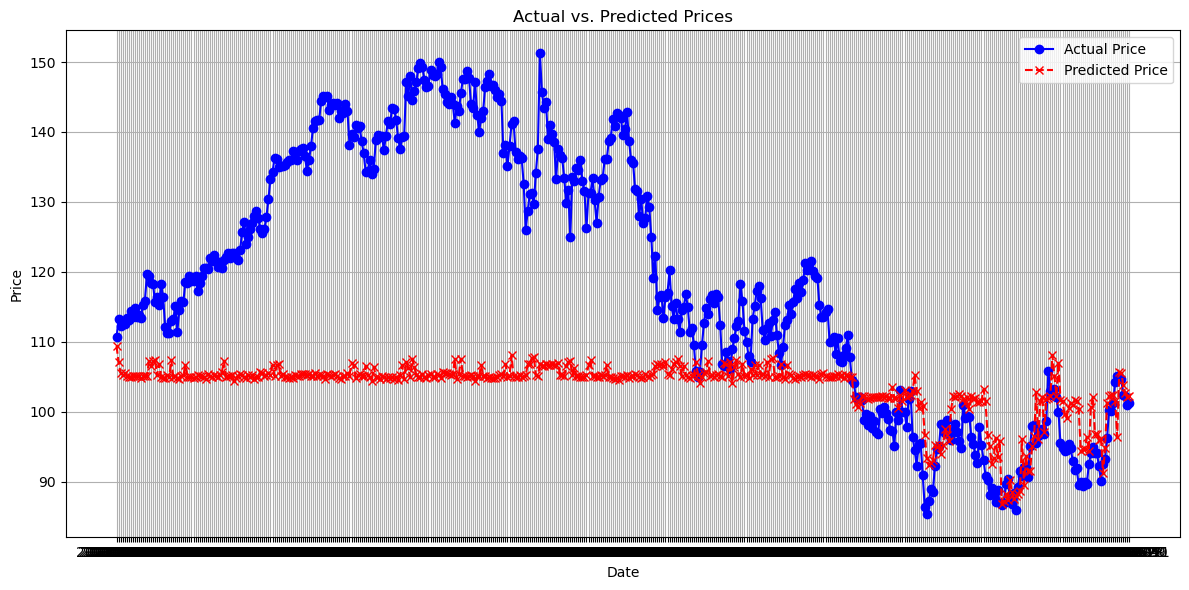

In [126]:
import matplotlib.pyplot as plt

# Assuming 'prediction_df' is your DataFrame with columns 'Date', 'Actual Price', and 'Predicted Price'

# Create a line graph
plt.figure(figsize=(12, 6))
plt.plot(prediction_df['Date'], prediction_df['Actual Price'], label='Actual Price', marker='o', linestyle='-', color='blue')
plt.plot(prediction_df['Date'], prediction_df['Predicted Price'], label='Predicted Price', marker='x', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the graph (you can also save it as an image using plt.savefig)
plt.show()


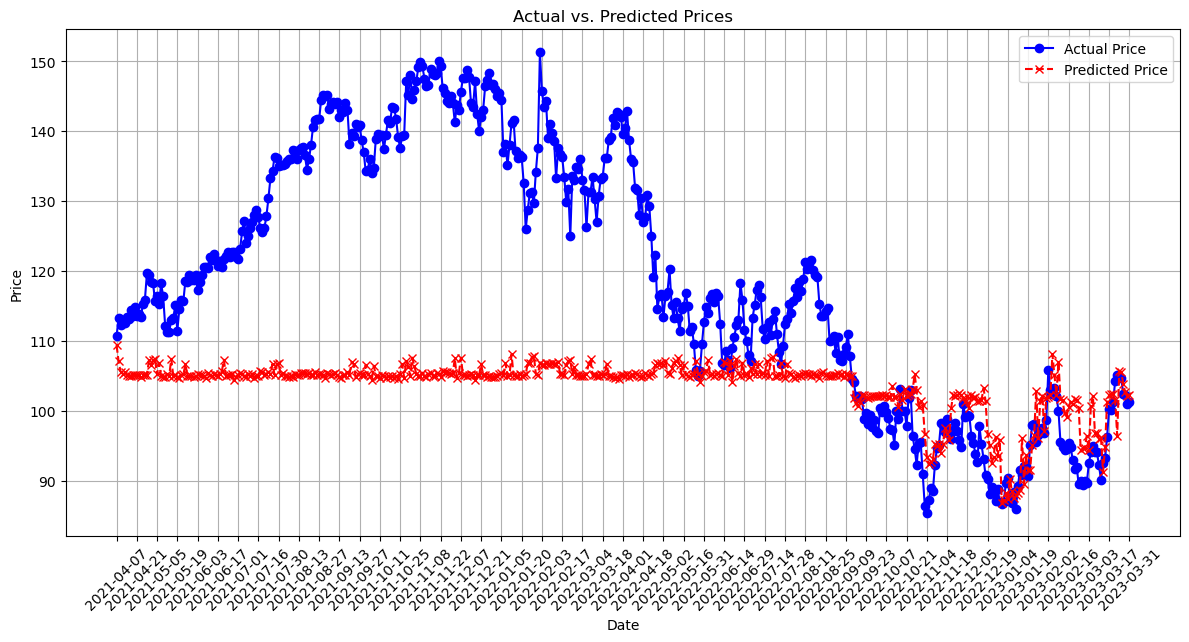

In [129]:
import matplotlib.pyplot as plt

# Assuming 'prediction_df' is your DataFrame with columns 'Date', 'Actual Price', and 'Predicted Price'

# Create a line graph
plt.figure(figsize=(12, 6))
plt.plot(prediction_df['Date'], prediction_df['Actual Price'], label='Actual Price', marker='o', linestyle='-', color='blue')
plt.plot(prediction_df['Date'], prediction_df['Predicted Price'], label='Predicted Price', marker='x', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Select a subset of dates to display (e.g., every 10th date)
n = 10  # Display every 10th date
plt.xticks(prediction_df['Date'][::n], rotation=45)

# Show the graph (you can also save it as an image using plt.savefig)
plt.show()


In [63]:
feature_x, target_y = create_feature_target_extraction(google_stock_df_modelling, 7)
train_features, test_features, train_target, test_target = train_test_split(feature_x, target_y, test_size=0.2, shuffle=False)

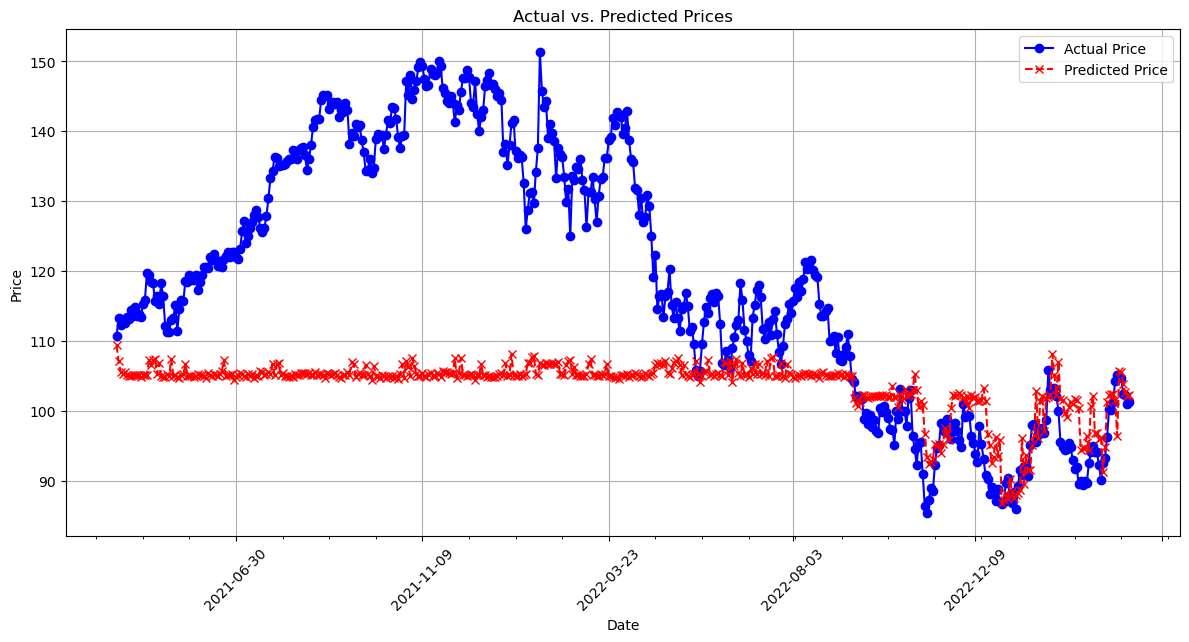

In [130]:
sni

In [64]:
train_features

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,19.67,19.94,19.44,19.57,19.57,98025876.0,19.68,19.92,19.62,19.85,...,20.02,20.02,115220664.0,20.05,20.41,20.03,20.22,20.22,91600308.0,NaN
1,19.68,19.92,19.62,19.85,19.85,69610320.0,19.69,19.79,19.47,19.58,...,20.22,20.22,91600308.0,20.22,20.47,20.22,20.36,20.36,73090836.0,NaN
2,19.69,19.79,19.47,19.58,19.58,81398520.0,19.65,19.66,19.05,19.17,...,20.36,20.36,73090836.0,20.43,20.43,20.21,20.25,20.25,79608312.0,NaN
3,19.65,19.66,19.05,19.17,19.17,132767100.0,19.25,20.11,19.18,20.02,...,20.25,20.25,79608312.0,20.21,20.21,19.93,20.06,20.06,99408492.0,NaN
4,19.25,20.11,19.18,20.02,20.02,231895872.0,20.04,20.12,19.39,20.02,...,20.06,20.06,99408492.0,20.10,20.59,20.10,20.50,20.50,91939968.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,102.41,103.44,100.96,101.07,101.07,31700000.0,101.49,101.85,100.15,101.35,...,101.62,101.62,35616000.0,101.59,101.97,100.19,101.24,101.24,27978000.0,103.061429
1997,101.49,101.85,100.15,101.35,101.35,46072000.0,101.38,102.42,100.70,101.53,...,101.24,101.24,27978000.0,101.11,102.46,100.27,102.29,102.29,26492000.0,102.995714
1998,101.38,102.42,100.70,101.53,101.53,33536000.0,102.00,103.21,101.40,102.07,...,102.29,102.29,26492000.0,102.65,103.13,101.81,102.32,102.32,27312000.0,102.495714
1999,102.00,103.21,101.40,102.07,102.07,28510000.0,102.59,103.38,101.45,101.63,...,102.32,102.32,27312000.0,102.72,104.31,102.35,103.13,103.13,42570000.0,102.434286


#Hyperopt

In [65]:
def XGBoostFunc(params):
    # Set the hyperparameters
    max_depth = params['max_depth']
    learning_rate = params['learning_rate']
    n_estimators = params['n_estimators']
    subsample = params['subsample']
    colsample_bytree = params['colsample_bytree']
    
    model_XGBOOST = xgb.XGBRegressor(max_depth=max_depth,
                             learning_rate=learning_rate,
                             n_estimators=n_estimators,
                             subsample=subsample,
                             colsample_bytree=colsample_bytree)
    model_XGBOOST.fit(train_features, train_target)
    predicted_values_XGBOOST = model_XGBOOST.predict(test_features)
    loss = mean_squared_error(test_target,predicted_values_XGBOOST)
    return loss


#Space Definition

The search space for the hyperparameters! The search space refers to the range or set of possible values that each hyperparameter can take during the optimization process.

n_estimators -> no. of estimators(individual decision tree that contributes to the final prediction)

subsample -> subsample represents the range or distribution of values that we want to explore during the optimization process. Choosing a lower value of subsample (e.g., closer to 0.5) means that each tree will be trained on a smaller subset of the training data, introducing more randomness and reducing overfitting. Selecting a higher value of subsample (e.g., closer to 1) means that each tree will use a larger fraction of the training data, with a higher risk of overfitting.

colsample_bytree -> controls the subset of features that are used to build each individual tree.

In [77]:
space = {
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
}

In [75]:
# Configure Hyperopt
trials = Trials()
max_evals = 50 

In [82]:
best = fmin(
    fn=XGBoostFunc,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=max_evals
)

100%|███████████████████████████████████| 50/50 [00:00<?, ?trial/s, best loss=?]


In [83]:
best

{'colsample_bytree': 0.6676923428657571,
 'learning_rate': 0.18739882251213452,
 'max_depth': 0,
 'n_estimators': 98,
 'subsample': 0.6607076774833937}

In [85]:
# Define the parameter values
params = {
     'colsample_bytree': 0.6676923428657571,
     'learning_rate': 0.18739882251213452,
     'max_depth': 0,
     'n_estimators': 98,
     'subsample': 0.6607076774833937
}

# Initialize the XGBoost regressor with the specified parameters
model_xgb_opt = xgb.XGBRegressor(**params)

# Define the window size (number of previous days to consider for prediction)
window_size = 7

predictions_xgb_opt = predicted_price_with_feature_extraction(model_xgb_opt, google_stock_df_modelling, window_size)

XGBoostError: [10:53:13] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_colmaker.cc:177: Check failed: param_.max_depth > 0 (0 vs. 0) : exact tree method doesn't support unlimited depth.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001333a36d5 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x00000001335c2ed4 xgboost::tree::ColMaker::Builder::Update(std::__1::vector<xgboost::detail::GradientPairInternal<float>, std::__1::allocator<xgboost::detail::GradientPairInternal<float>>> const&, xgboost::DMatrix*, xgboost::RegTree*) + 1028
  [bt] (2) 3   libxgboost.dylib                    0x00000001335c1cd4 xgboost::tree::ColMaker::Update(xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float>>*, xgboost::DMatrix*, xgboost::common::Span<xgboost::HostDeviceVector<int>, 18446744073709551615ul>, std::__1::vector<xgboost::RegTree*, std::__1::allocator<xgboost::RegTree*>> const&) + 484
  [bt] (3) 4   libxgboost.dylib                    0x00000001334a74ed xgboost::gbm::GBTree::BoostNewTrees(xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float>>*, xgboost::DMatrix*, int, std::__1::vector<std::__1::unique_ptr<xgboost::RegTree, std::__1::default_delete<xgboost::RegTree>>, std::__1::allocator<std::__1::unique_ptr<xgboost::RegTree, std::__1::default_delete<xgboost::RegTree>>>>*) + 2317
  [bt] (4) 5   libxgboost.dylib                    0x00000001334a0235 xgboost::gbm::GBTree::DoBoost(xgboost::DMatrix*, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float>>*, xgboost::PredictionCacheEntry*, xgboost::ObjFunction const*) + 501
  [bt] (5) 6   libxgboost.dylib                    0x00000001334c22b9 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 681
  [bt] (6) 7   libxgboost.dylib                    0x00000001333bebdf XGBoosterUpdateOneIter + 143
  [bt] (7) 8   libffi.7.dylib                      0x000000010d568ead ffi_call_unix64 + 85
  [bt] (8) 9   ???                                 0x0000000309df9600 0x0 + 13050549760



In [86]:
predictions_xgb_opt

NameError: name 'predictions_xgb_opt' is not defined

In [0]:
evaluate(predictions_xgb_opt)

#Parallelizing Hyperopt Tuning

In [0]:
from hyperopt import SparkTrials
import mlflow

#Spark Trials

SparkTrials takes 2 optional arguments:

parallelism: Number of models to fit and evaluate concurrently. The default is the number of available Spark task slots.

timeout: Maximum time (in seconds) that fmin() can run. The default is no maximum time limit.

#Types of search algo 
hyperopt.tpe.suggest: Tree of Parzen Estimators, a Bayesian approach which iteratively and adaptively selects new hyperparameter settings to explore based on past results
hyperopt.rand.suggest: Random search, a non-adaptive approach that samples over the search space

In [0]:
spark_trials = SparkTrials(4)
max_evals_spark = 100

with mlflow.start_run():
  argmin = fmin(
    fn=XGBoostFunc,
    space=space,
    algo=rand.suggest,
    max_evals=max_evals_spark,
    trials=spark_trials)

In [0]:
argmin

In [0]:
# Define the parameter values
params = {
    'colsample_bytree': 0.6168136805920839,
    'learning_rate': 0.5388100199935252,
    'max_depth': 7,
    'n_estimators': 143,
    'subsample': 0.5878989107028276
}

# Initialize the XGBoost regressor with the specified parameters
model_xgb_opt = xgb.XGBRegressor(**params)

# Define the window size (number of previous days to consider for prediction)
window_size = 7

predictions_xgb_opt_spark_rand = predicted_price(model_xgb_opt, google_stock_df_modelling, window_size)
evaluate(predictions_xgb_opt_spark_rand)

In [0]:
spark_trials = SparkTrials(4)
max_evals_spark = 100

with mlflow.start_run():
  argmin_tpe = fmin(
    fn=XGBoostFunc,
    space=space,
    algo=tpe.suggest,
    max_evals=max_evals_spark,
    trials=spark_trials)

In [0]:
argmin_tpe

In [0]:
# Define the parameter values
params = {
    'colsample_bytree': 0.7363397845367727,
    'learning_rate': 0.9791674584219473,
    'max_depth': 4,
    'n_estimators': 37,
    'subsample': 0.7066230640051272
}

# Initialize the XGBoost regressor with the specified parameters
model_xgb_opt = xgb.XGBRegressor(**params)

# Define the window size (number of previous days to consider for prediction)
window_size = 7

predictions_xgb_opt_spark_tpe = predicted_price(model_xgb_opt, google_stock_df_modelling, window_size)
evaluate(predictions_xgb_opt_spark_tpe)

#XGBoost vs XGBRFRegressor
While XGBoost primarily uses decision trees as base learners, XGBRFRegressor combines the concepts of gradient boosting and random forests. 

XGBoost performed slightly better than XGBRFRegressor based on MSE, RMSE and MAE

In [0]:
model_XGBFR = XGBRFRegressor()
model_XGBFR.fit(train_features, train_target)

In [0]:
predicted_values_XGBFR = model_XGBFR.predict(test_features)

In [0]:
print("MSE",round(mean_squared_error(test_target,predicted_values_XGBFR), 3))
print("RMSE",round(np.sqrt(mean_squared_error(test_target,predicted_values_XGBFR)), 3))
print("MAE",round(mean_absolute_error(test_target,predicted_values_XGBFR), 3))

#Linear vs XGBoost
Based on MSE, RMSE, MAE, Linear Regression performed better than XGBOOST because it has lower values.

In [0]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [0]:
train_data = lgb.Dataset(train_features, label=train_target)

In [0]:
model_lightGBM = lgb.train(params, train_data, 100)
predicted_values_lightGBM = model_lightGBM.predict(test_features)

In [1]:
print("MSE",round(mean_squared_error(test_target,predicted_values_lightGBM), 3))
print("RMSE",round(np.sqrt(mean_squared_error(test_target,predicted_values_lightGBM)), 3))
print("MAE",round(mean_absolute_error(test_target,predicted_values_lightGBM), 3))

NameError: name 'mean_squared_error' is not defined

#LightGBM vs XGBoost
Kind of similar performance of the two models